# Convolutional Network in Keras

Convolutional neural networks (CNN) play an important part in modern machine learning applications as they allow to analyse a wide range of data such as images or text automatically. CNNs are used to detect features of the data automatically, for example if an image is analysed by a CNN, it can be trained to tell cats apart from dogs.

A widely known practice dataset for image recognition is the MNIST dataset The data contain a large number of handwritten digits in the range 0...9 and the task focuses on recognizing the images. The task was pioneered by Yann LeCun and others in 1998 ([original paper](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf) [Yann LeCun's Webpage for MNIST](http://yann.lecun.com/exdb/lenet/)). 

The images are snipplets of 28 pixels x 28 pixels = 784 pixels and there are n=10 digits to recognise.

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime as dt
from sklearn.metrics import confusion_matrix

%pylab inline
# large figures
rcParams['figure.figsize'] = 8, 6

print(tf.__version__)

Populating the interactive namespace from numpy and matplotlib
2.1.0


## Loading the data

As this is a popular dataset to get to know CNNs, the data are available as part of TensorFlow:

There are 6,000 images avaiable, each with a size of 28x28 pixels.
The "shape" of the dataset is therefore $(28,28)$.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape)

(60000, 28, 28)


The images look like this:

True label: 3


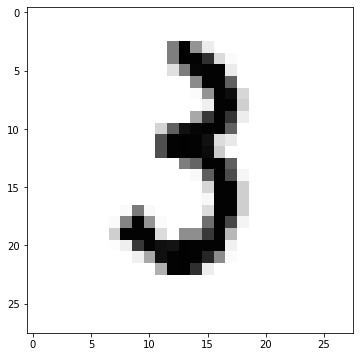

In [3]:
index = 1234
print('True label: {}'.format(y_train[index]) )
plt.imshow(x_train[index], cmap='Greys')
plt.show()

First we make the shape of the input tensor we will use in our model explicit:
 * length of the trainings and test tensor
 * 28x28 pixels
 * grayscale (1 colour)

We also need to normalise the colour range by dividing by 255 (RGB range).
In addition, we cast the values to floating point nubmers with 32 bit accuracy so they all have a well defined state.

In [4]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')


x_train = x_train/255
x_test = x_test/255

print('Final shape of input tensor {}'.format(x_train.shape))


Final shape of input tensor (60000, 28, 28, 1)


## A Simple model

We start with a very simple model that has only one convloutional layer.
We then add one fully connected (or dense) layer with ReLU activation function 
and then use a fully connected layer with 10 nodes (one for each digit in $0,\ldots,9$)
with softmax activation. The latter converts the output of the nodes into a probability.

We also add a dropout layer after the first fully connected layer to regularize the network.
Using the Keras interface, the model is then:

In [5]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, 
                                 kernel_size=(3,3), 
                                 strides=(1,1),
                                 padding='valid',
                                 activation='relu', 
                                 input_shape=(28,28,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# flatten the 2D convolution layers before adding a fully connected (dense) layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128,activation=tf.nn.relu))

#add dropout for regularisation
model.add(tf.keras.layers.Dropout(0.5))

# final fully connected (dense) layer which returns a probability for each of the digits 0...9
model.add(tf.keras.layers.Dense(10,activation=tf.nn.softmax))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               692352    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
__________________________________________________

Note that this simple model has already almost 700,000 free parameters (network weights) that need to be optimized.

We now specify how we train the network.
We need to specify the optimizer used during training. Several choices exist, as a good practice, the Adam Optimizer (See the [paper](https://arxiv.org/abs/1412.6980) and the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) for more details) is a good starting point.

We also use cross-entropy for the loss function as this is a classification problem.

Furthermore, we add the accuracy as the metric we want to monitor during network training.


In [6]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

We then train the model by calling ```model.fit()``` using 5 epochs to complete the training quickly.

In [7]:
model.fit(x_train,y_train, epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 31s 513us/sample - loss: 1.6547 - sparse_categorical_accuracy: 0.8061
Epoch 2/5
60000/60000 [==============================] - 30s 506us/sample - loss: 1.5884 - sparse_categorical_accuracy: 0.8725
Epoch 3/5
60000/60000 [==============================] - 29s 478us/sample - loss: 1.5851 - sparse_categorical_accuracy: 0.8759
Epoch 4/5
60000/60000 [==============================] - 28s 473us/sample - loss: 1.5836 - sparse_categorical_accuracy: 0.8774
Epoch 5/5
60000/60000 [==============================] - 32s 537us/sample - loss: 1.5895 - sparse_categorical_accuracy: 0.8716


Keras also provides a convenient function to evaluate the performance on the independent test data we have retained.

In [8]:
model.evaluate(x_test,y_test)

10000/10000 [==============================] - 2s 210us/sample - loss: 1.5312 - sparse_categorical_accuracy: 0.9300


[1.5311651317596435, 0.93]

The model performance is about 94% on an independent test sample - which is ok for a first go.
More complex models achieve more than 99% accuracy, a summary can be found on Yann LeCuns [MNIST page](http://yann.lecun.com/exdb/mnist/index.html)

We can also make some predictions and look at the confustion matrix.

In [9]:
predictions = model.predict(x_test)
y_hat = tf.argmax(predictions, axis=1)

[[ 972    2    1    0    0    0    2    2    1    0]
 [   0 1126    3    0    0    0    5    0    1    0]
 [  16   12  977    1    6    0    1   11    5    3]
 [  14    9   73  825    3   28    7   12   36    3]
 [   1    2    7    0  954    0    5    0    2   11]
 [   7    2    4    4    4  783   18    3   63    4]
 [  25    4    3    0    9    1  907    0    9    0]
 [   1    9   28    1    9    1    0  953    0   26]
 [  17   15   20    1   18    0    2   13  880    8]
 [  15   10    2    3   34    5    0    9    8  923]]


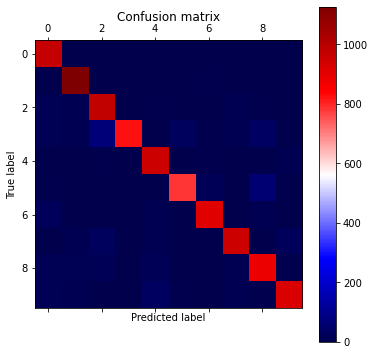

In [10]:
# Compute confusion matrix
cm = confusion_matrix(y_test,y_hat)

print(cm)

# Show confusion matrix 
plt.matshow(cm, cmap='seismic')
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# A More Complex Model

We now create a more complex model by adding two convolutional layers and increase the number of nodes 
in the intermediate fully connected layer.

In [11]:
model = tf.keras.Sequential()
model.add((tf.keras.layers.Conv2D(filters=32, kernel_size=[5,5], padding='same', activation='relu',input_shape=(28,28,1 ))))
model.add((tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)))
model.add((tf.keras.layers.Conv2D(filters=64, kernel_size=[5,5], padding='same', activation='relu' )))
model.add((tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)))
model.add((tf.keras.layers.Flatten()))
model.add((tf.keras.layers.Dense(1024, activation='relu')))
model.add((tf.keras.layers.Dropout(0.5)))
model.add((tf.keras.layers.Dense(10, activation='softmax')))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              3212288   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)             

Note how this moderate increase in complexity increased the number of parameters from ca. 700,000 to more than 3 Million already.

In [12]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [13]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 141s 2ms/sample - loss: 2.3019 - sparse_categorical_accuracy: 0.1099
Epoch 2/10
60000/60000 [==============================] - 151s 3ms/sample - loss: 2.3013 - sparse_categorical_accuracy: 0.1124
Epoch 3/10
60000/60000 [==============================] - 147s 2ms/sample - loss: 2.3014 - sparse_categorical_accuracy: 0.1124
Epoch 4/10
60000/60000 [==============================] - 160s 3ms/sample - loss: 2.3013 - sparse_categorical_accuracy: 0.1124
Epoch 5/10
60000/60000 [==============================] - 145s 2ms/sample - loss: 2.3013 - sparse_categorical_accuracy: 0.1124
Epoch 6/10
60000/60000 [==============================] - 145s 2ms/sample - loss: 2.3014 - sparse_categorical_accuracy: 0.1124
Epoch 7/10
60000/60000 [==============================] - 166s 3ms/sample - loss: 2.3014 - sparse_categorical_accuracy: 0.1124
Epoch 8/10
60000/60000 [==============================] - 149s 2ms/sample - loss: 2.3014

In [14]:
model.evaluate(x_test,y_test)

10000/10000 [==============================] - 6s 616us/sample - loss: 2.3011 - sparse_categorical_accuracy: 0.1135


[2.301110806274414, 0.1135]

In [ ]:
history_dict = history.history
history_dict.keys()
loss_values = history_dict['loss']
acc_values = history_dict['sparse_categorical_accuracy']
epochs = range(1, len(loss_values) + 1)

fig, axes = plt.subplots(2, sharex=True)
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(loss_values)
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Iteration", fontsize=14)
axes[1].plot(acc_values)
plt.show()